# TabNet

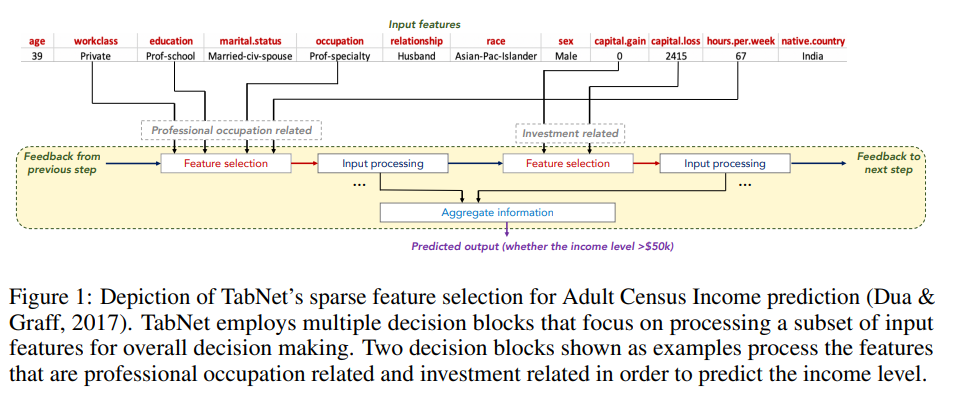

Please refer to https://arxiv.org/pdf/1908.07442.pdf about the mechanics and basis of TabNet.

For Guass rank, please refer to https://github.com/aldente0630/gauss_rank_scaler

In [ ]:
!pip install ../input/pytorchtabnet/pytorch_tabnet-3.1.1-py3-none-any.whl

In [ ]:
!lscpu |grep 'Model name'

In [ ]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder 
import pickle
import scipy as sc
import random

In [ ]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
#import lightgbm as lgb
import warnings
import torch
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)

In [ ]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/gauss-rank-scaler/gauss_rank_scaler.py", dst = "../working/gauss_rank_scaler.py")

# import all our functions
from gauss_rank_scaler import GaussRankScaler

In [ ]:
#hyper
NFOLDS = 5
seed = 42

In [ ]:
train = pd.read_csv("../input/optiver-dfs/train.csv")
train = train.drop("Unnamed: 0", axis=1)
train

In [ ]:
for col in train.columns.to_list()[4:]:
    train[col] = train[col].fillna(train[col].mean())

In [ ]:
from sklearn import datasets
from sklearn import model_selection

def create_folds(data, num_splits,target):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data[target], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

train = create_folds(train, NFOLDS,"target")

In [ ]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


In [ ]:
scales = train.drop(['row_id', 'target', 'time_id',"stock_id","kfold"], axis = 1).columns.to_list()

In [ ]:
scaler = GaussRankScaler()
scaler.fit(train[scales])

In [ ]:
train

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    
    if (y_true == 0).any():
        raise ValueError("Root Mean Square Percentage Error cannot be used when "
                         "targets contain zero values.")
        
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0)).item()

    return loss

In [ ]:
class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return rmspe(y_true, y_score)

In [ ]:
le=LabelEncoder()
le.fit(train["stock_id"])
train["stock_id"] = le.transform(train["stock_id"])

with open( 'stock_id_encoder.txt', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
tabnet_params = dict(
    n_d = 32,
    n_a = 32,
    n_steps = 3,
    gamma = 1.3,
    lambda_sparse = 0,
    optimizer_fn = optim.Adam,
    optimizer_params = dict(lr = 1e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
    scheduler_fn = ReduceLROnPlateau,
    seed = 42,
    #verbose = 5,
    cat_dims=[len(le.classes_)], cat_emb_dim=[10], cat_idxs=[-1] # define categorical features
)

In [ ]:
feature_cols = train.columns.tolist()
feature_cols = [ii for ii in feature_cols if not ii in ['row_id', 'target', 'time_id', 'kfold']]
target_cols = ['target']

In [ ]:
SEED = 42

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(SEED)

In [ ]:
max_epochs = 50

In [ ]:
#unsupervised model maybe, not have enough time ~4hours ----------------------------------------

In [ ]:
def data_tranform(traindf, validdf):
    
    x_train, x_val = traindf[feature_cols], validdf[feature_cols]
    y_train, y_val = traindf[target_cols], validdf[target_cols]
    # Transform stock id to a numeric value and normalize other features
    x_train_arr = np.hstack((scaler.transform(x_train[scales].values), x_train[["stock_id"]].values))
    x_val_arr = np.hstack((scaler.transform(x_val[scales].values), x_val[["stock_id"]].values))
    
    y_weight = 1/np.square(traindf["target"])

    
    
    print(x_train.shape, y_train.shape)
    
    
    y_train_arr = y_train.values
    y_val_arr = y_val.values
    
    return x_train_arr, x_val_arr, y_train_arr, y_val_arr, y_weight

In [ ]:
for fold in range(NFOLDS):
    # initialize random seed

    print(f'Training fold {fold + 1}')

    traindf = train[train["kfold"]!=fold].reset_index(drop=True)
    validdf = train[train["kfold"]==fold].reset_index(drop=True)
    
    
    x_train_arr, x_val_arr, y_train_arr, y_val_arr, y_weight = data_tranform(traindf, validdf)
    
    #print(x_train.shape, y_train.shape)
    
    
    
    random_seed(SEED)
    
    clf = TabNetRegressor(**tabnet_params)
    
    
    
    clf.fit(
        X_train=x_train_arr, y_train=y_train_arr,
        eval_set=[(x_train_arr, y_train_arr), (x_val_arr, y_val_arr)],
        eval_name=['train', 'valid'],
        eval_metric=[RMSPE],
        max_epochs=max_epochs,
        patience=10,
        batch_size=1024*2, virtual_batch_size=128*2,
        num_workers=4,
        drop_last=False,
        weights = y_weight,
        loss_fn=nn.L1Loss(),
        #from_unsupervised=unsupervised_model,
    )

    # Add predictions to the out of folds array
    #oof_predictions[val_ind] = clf.predict(x_val.values).reshape(-1)

    #save model
    #unsupervised_saving_path_name = "./unsupervised_fold_"+str(fold)
    #saved_filepath = unsupervised_model.save_model(unsupervised_saving_path_name)

    #print("un saved_filepath:", saved_filepath
    supervised_saving_path_name = "./supervised_fold_"+str(fold)
    saved_filepath = clf.save_model(supervised_saving_path_name)

    print("su saved_filepath:", saved_filepath)

----